In [3]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)


In [4]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [5]:
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data/gene_seq_train.csv')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data/res_train.csv')
#don't touch test data, split out validation data from training data during training
test_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data/gene_seq_test.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data/res_test.csv')

In [6]:
N_samples = train_data.shape[0]
DRUGS = ['AMIKACIN',
 'CAPREOMYCIN',
 'CIPROFLOXACIN',
 'ETHAMBUTOL',
 'ETHIONAMIDE',
 'ISONIAZID',
 'KANAMYCIN',
 'LEVOFLOXACIN',
 'MOXIFLOXACIN',
 'OFLOXACIN',
 'PYRAZINAMIDE',
 'RIFAMPICIN',
 'STREPTOMYCIN']

DRUGS = train_target.columns
LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature importance

In [7]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())


# Dateset

In [1]:
# Julian's code - implement this, might be faster
class OneHotSeqsDataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
    ):
        self.seq_df = seq_df[target_loci]
        self.res_df = res_df[target_drugs]
        if not self.seq_df.index.equals(self.res_df.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df.iloc[index].str.cat()
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df.loc[index].str.cat()
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_df.shape[0]
    
training_dataset = OneHotSeqsDataset(train_data, train_target, one_hot_dtype=torch.float)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.8), len(training_dataset)-int(len(training_dataset)*0.8)])



NameError: name 'torch' is not defined

In [9]:
# class seq_dataset(Dataset):
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y
#     def __getitem__(self, index):
#         seqs_comb = self.x.iloc[index,1:].str.cat(sep='X'*30)
#         seqs_comb = one_hot_torch(seqs_comb)
#         seqs_comb = seqs_comb.permute(2, 0, 1).contiguous().view(4, 57350)
#         res = torch.as_tensor(self.y.iloc[index,:].values.tolist())
        
#         return seqs_comb, res
#     def __len__(self):
#         return len(self.x)

# training_dataset = seq_dataset(train_data, train_target)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.8), len(training_dataset)-int(len(training_dataset)*0.8)])

# Model

In [10]:
class Model(nn.Module):
    def __init__(self, in_channel = 4, hidden_channel = 64, out_channel=13, batch_size=1):
        super(Model, self).__init__()
        self.batch_size = batch_size
        # self.feature_extraction = nn.Conv1d(in_channels, hidden, kernel_size=kernel_size),
        self.conv1 = nn.Conv1d(in_channel, hidden_channel, kernel_size=25, stride=1)
        self.conv2 = nn.Conv1d(hidden_channel, hidden_channel, kernel_size=25, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = None
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # ic('c1',x.size())
        x = F.relu(self.conv2(x))
        # ic('c2',x.size())
        
        x = F.relu(self.pool(x))
        # ic('pool',x.size()) 
        x = torch.max(x, dim=1).values
        # ic('max',x.size())
        # print('x after maxpool:', x.size())
        x = x.view(x.size(0), -1)
        # print('x after view:', x.size())

        if self.fc is None:
            # Set the input size based on x the first time forward is called
            # x = x.T
            input_size = x.size(1)
            self.fc = nn.Linear(input_size, 13).to(x.device)  # Ensure the layer is on the same device as x
        # print(x.size())

        x = torch.sigmoid(self.fc(x))
        x = torch.squeeze(x)
        # print('output:', x)
        # print('1111')             
        # first_dim_size = x.size(0)
        # x = x.reshape(first_dim_size, -1).contiguous()
        # first_dim_size = x.size(0)
        # print('size after research', x.size())
        return x

torch.cuda.empty_cache()

model = Model(in_channel = 4, hidden_channel = 64, out_channel=13, batch_size=batch_size)
model = model.float()
model = model.to(device)

epoch = 20
batch_size = 64
lr = 0.001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
# criterion = nn.MSELoss()
criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [11]:
torch.cuda.empty_cache()
import gc; gc.collect()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        self.conv_layers = nn.ModuleList(
            self._conv_layer(num_filters, num_filters, 3)
            for _ in range(num_conv_layers)
        )
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.Sigmoid()) #difference between sequential and nn.moduleList?
        )

    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x = self.prediction_layer(x)
        return x

model = Model(
num_classes=13,
num_filters=128,
num_conv_layers=2,
num_dense_neurons=64, # batch_size = 64
num_dense_layers=2,
return_logits=True,
).to(device)

epoch = 50
batch_size = 64
lr = 0.0085

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
# criterion = nn.MSELoss()
criterion = masked_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training

In [12]:
ic.disable()
# ic.enable()
train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    
    for x, y in train_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)

        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
# For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print(x_batch)
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        loss_train = criterion(y_batch, pred)
        ic(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('test')
        for x, y in test_loader:
            x_batch = x.to(device)
            y_batch = y.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    print('==='*10)

  2%|▏         | 1/50 [01:10<57:21, 70.23s/it]

Epoch 1
Training loss: 10.597434997558594
Validation loss: 10.461796064833567


  4%|▍         | 2/50 [02:18<55:08, 68.92s/it]

Epoch 2
Training loss: 10.396098136901855
Validation loss: 10.40257651576249


  6%|▌         | 3/50 [03:25<53:33, 68.37s/it]

Epoch 3
Training loss: 10.401031494140625
Validation loss: 10.423938687531738


  8%|▊         | 4/50 [04:33<52:09, 68.03s/it]

Epoch 4
Training loss: 10.386526107788086
Validation loss: 10.387912971574174


 10%|█         | 5/50 [05:40<50:46, 67.69s/it]

Epoch 5
Training loss: 10.316341400146484
Validation loss: 10.296622882832462


 12%|█▏        | 6/50 [06:47<49:25, 67.39s/it]

Epoch 6
Training loss: 10.314620018005371
Validation loss: 10.344651828954458


 14%|█▍        | 7/50 [07:54<48:20, 67.46s/it]

Epoch 7
Training loss: 10.361194610595703
Validation loss: 10.281518802283324


 16%|█▌        | 8/50 [09:01<47:03, 67.22s/it]

Epoch 8
Training loss: 10.25601863861084
Validation loss: 10.273043030974288


 18%|█▊        | 9/50 [10:08<45:55, 67.20s/it]

Epoch 9
Training loss: 10.24858283996582
Validation loss: 10.278882309196641


 20%|██        | 10/50 [11:15<44:44, 67.12s/it]

Epoch 10
Training loss: 10.249676704406738
Validation loss: 10.28766811163585


 22%|██▏       | 11/50 [12:22<43:33, 67.01s/it]

Epoch 11
Training loss: 10.196913719177246
Validation loss: 10.2725043557514


 24%|██▍       | 12/50 [13:29<42:27, 67.03s/it]

Epoch 12
Training loss: 10.260120391845703
Validation loss: 10.26922933316258


 26%|██▌       | 13/50 [14:37<41:26, 67.22s/it]

Epoch 13
Training loss: 10.187143325805664
Validation loss: 10.260849291663392


 28%|██▊       | 14/50 [15:44<40:22, 67.28s/it]

Epoch 14
Training loss: 10.23169994354248
Validation loss: 10.271679082954671


 30%|███       | 15/50 [16:52<39:18, 67.40s/it]

Epoch 15
Training loss: 10.216150283813477
Validation loss: 10.273873958141873


 32%|███▏      | 16/50 [18:00<38:17, 67.57s/it]

Epoch 16
Training loss: 10.287328720092773
Validation loss: 10.259512884902596


 34%|███▍      | 17/50 [19:08<37:17, 67.81s/it]

Epoch 17
Training loss: 10.24237060546875
Validation loss: 10.259469742131762


 36%|███▌      | 18/50 [20:16<36:07, 67.72s/it]

Epoch 18
Training loss: 10.243048667907715
Validation loss: 10.25085877444195


 38%|███▊      | 19/50 [21:23<34:57, 67.68s/it]

Epoch 19
Training loss: 10.230441093444824
Validation loss: 10.267150994423046


 40%|████      | 20/50 [22:31<33:47, 67.59s/it]

Epoch 20
Training loss: 10.24195671081543
Validation loss: 10.26943134863648


 42%|████▏     | 21/50 [23:38<32:38, 67.53s/it]

Epoch 21
Training loss: 10.190428733825684
Validation loss: 10.264453223072396


 44%|████▍     | 22/50 [24:46<31:35, 67.70s/it]

Epoch 22
Training loss: 10.293571472167969
Validation loss: 10.263569924010866


 46%|████▌     | 23/50 [25:54<30:29, 67.77s/it]

Epoch 23
Training loss: 10.1912841796875
Validation loss: 10.288950490165165


 48%|████▊     | 24/50 [27:01<29:15, 67.50s/it]

Epoch 24
Training loss: 10.215019226074219
Validation loss: 10.26493205850847


 50%|█████     | 25/50 [28:08<28:03, 67.35s/it]

Epoch 25
Training loss: 10.184682846069336
Validation loss: 10.251991967384384


 52%|█████▏    | 26/50 [29:15<26:53, 67.22s/it]

Epoch 26
Training loss: 10.256447792053223
Validation loss: 10.281879115018446


 54%|█████▍    | 27/50 [30:22<25:44, 67.17s/it]

Epoch 27
Training loss: 10.33318042755127
Validation loss: 10.28558399185406


 56%|█████▌    | 28/50 [31:29<24:39, 67.24s/it]

Epoch 28
Training loss: 10.183939933776855
Validation loss: 10.263907380830128


 58%|█████▊    | 29/50 [32:36<23:30, 67.15s/it]

Epoch 29
Training loss: 10.196135520935059
Validation loss: 10.258023400306087


 60%|██████    | 30/50 [33:43<22:22, 67.14s/it]

Epoch 30
Training loss: 10.215973854064941
Validation loss: 10.254903555733625


 62%|██████▏   | 31/50 [34:51<21:15, 67.13s/it]

Epoch 31
Training loss: 10.221610069274902
Validation loss: 10.277314771406502


 64%|██████▍   | 32/50 [35:58<20:09, 67.19s/it]

Epoch 32
Training loss: 10.18200397491455
Validation loss: 10.271721977676991


 66%|██████▌   | 33/50 [37:05<19:02, 67.23s/it]

Epoch 33
Training loss: 10.225593566894531
Validation loss: 10.25355399959722


 68%|██████▊   | 34/50 [38:12<17:55, 67.19s/it]

Epoch 34
Training loss: 10.235847473144531
Validation loss: 10.271137075061556


 70%|███████   | 35/50 [39:19<16:47, 67.18s/it]

Epoch 35
Training loss: 10.230788230895996
Validation loss: 10.257261836751827


 72%|███████▏  | 36/50 [40:26<15:38, 67.05s/it]

Epoch 36
Training loss: 10.239337921142578
Validation loss: 10.277716721242244


 74%|███████▍  | 37/50 [41:33<14:30, 66.98s/it]

Epoch 37
Training loss: 10.20287799835205
Validation loss: 10.249471014746689


 76%|███████▌  | 38/50 [42:40<13:22, 66.90s/it]

Epoch 38
Training loss: 10.250569343566895
Validation loss: 10.281799595152153


 78%|███████▊  | 39/50 [43:47<12:17, 67.03s/it]

Epoch 39
Training loss: 10.185399055480957
Validation loss: 10.250954337278648


 80%|████████  | 40/50 [44:54<11:10, 67.07s/it]

Epoch 40
Training loss: 10.18047046661377
Validation loss: 10.249845150310934


 82%|████████▏ | 41/50 [46:01<10:02, 67.00s/it]

Epoch 41
Training loss: 10.198519706726074
Validation loss: 10.236877482308513


 84%|████████▍ | 42/50 [47:08<08:56, 67.12s/it]

Epoch 42
Training loss: 10.184061050415039
Validation loss: 10.252930046714116


 86%|████████▌ | 43/50 [48:16<07:50, 67.28s/it]

Epoch 43
Training loss: 10.17332935333252
Validation loss: 10.289861490850233


 88%|████████▊ | 44/50 [49:23<06:43, 67.23s/it]

Epoch 44
Training loss: 10.21182632446289
Validation loss: 10.261169638344644


 90%|█████████ | 45/50 [50:31<05:36, 67.29s/it]

Epoch 45
Training loss: 10.190604209899902
Validation loss: 10.24564608309714


 92%|█████████▏| 46/50 [51:38<04:28, 67.19s/it]

Epoch 46
Training loss: 10.23549747467041
Validation loss: 10.267837793277106


 94%|█████████▍| 47/50 [52:45<03:21, 67.29s/it]

Epoch 47
Training loss: 10.233972549438477
Validation loss: 10.257614971104577


 96%|█████████▌| 48/50 [53:52<02:14, 67.20s/it]

Epoch 48
Training loss: 10.226142883300781
Validation loss: 10.272104068514585


 98%|█████████▊| 49/50 [55:00<01:07, 67.33s/it]

Epoch 49
Training loss: 10.189316749572754
Validation loss: 10.250697106142875


100%|██████████| 50/50 [56:07<00:00, 67.34s/it]

Epoch 50
Training loss: 10.20498275756836
Validation loss: 10.253404119515428


### testing out hyper-parameters

In [33]:
def hyper_params_test(lr, fc_dr=0.2,cnn_dr=0, epoch=20):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '==='*10)
    
    model = Model(
    num_classes=13,
    num_filters=128,
    num_conv_layers=2,
    num_dense_neurons=64, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    dense_dropout_rate=fc_dr,
    conv_dropout_rate=cnn_dr
    ).to(device)

    epoch = epoch
    batch_size = 64
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            # y_batch = y_batch.view(-1)

            # y_batch = one_hot_torch(y).to(device)
            # print('batch y size before flatten:',y_batch.size())
            # y_batch = y_batch.flatten()
            # print('batch y size after flatten:',y_batch.size())
            # print(x_batch.size())
            # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
            # print(x_batch.size())
            pred = model(x_batch.float())
            # print(x_batch)
            # print(pred)
            # pred = pred.unsqueeze(0)
            # ic(pred)
            # ic(y_batch)
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')


        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())
                # pred = pred.unsqueeze(0)

                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        # print(f'Epoch {e}')
        # print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        # print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # print(train_batch_loss)
        # print(test_batch_loss)
        # print(f"Training loss: {np.mean(train_batch_loss)}")
        # print(f"Validation loss: {np.mean(test_batch_loss)}")
        # print('==='*10)
    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.savefig(f'./graphs/loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')
        

lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


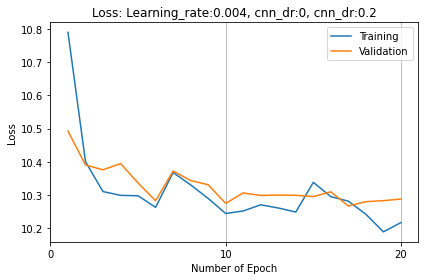

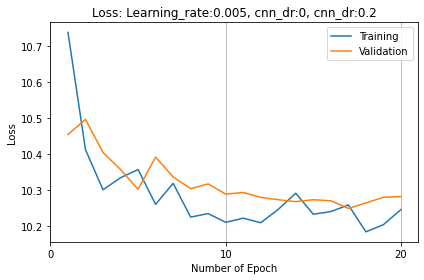

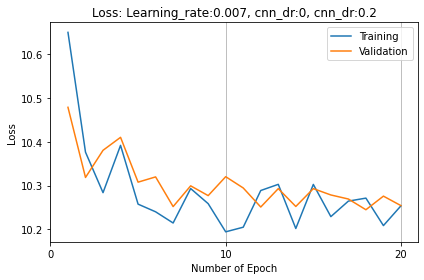

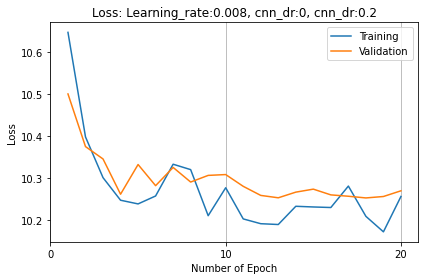

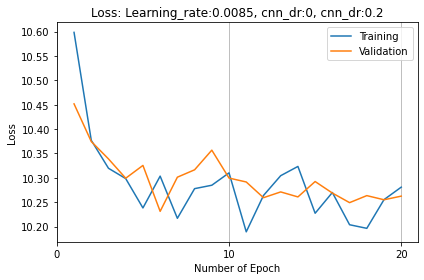

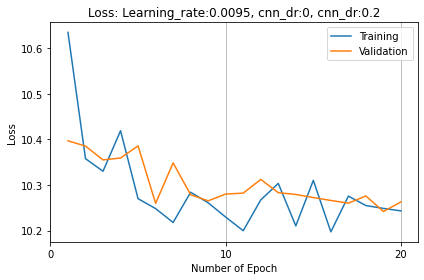

In [34]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

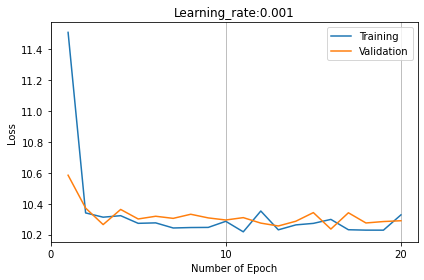

In [17]:
#%%
fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")